In [1]:
#@title import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing

# read data from csv file
df = pd.read_csv("yellow_tripdata_2018-06.csv") 

df['tpep_pickup_datetime'] = pd.to_datetime(df.tpep_pickup_datetime)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)
df["pickup_weekday_name"] = df.tpep_pickup_datetime.dt.weekday_name
df["pickup_hour"] = df.tpep_pickup_datetime.dt.hour
df["dropoff_hour"] = df.tpep_dropoff_datetime.dt.hour
df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds()

df1 = df.loc[:,['pickup_weekday_name', 'pickup_hour', 'tpep_pickup_datetime','tpep_dropoff_datetime','trip_duration', 'PULocationID', 'DOLocationID','trip_distance', 'passenger_count']]

df1 = df1.query("datetime.datetime(2018,6,1,0,0,0) <= tpep_pickup_datetime < datetime.datetime(2018,7,1,0,0,0)")

df1['pick_time'] = [d.time() for d in df1['tpep_pickup_datetime']]
df1 = df1.query("datetime.time(17,0,0) <= pick_time < datetime.time(20,0,0)")
df1 = df1.drop(['pick_time'],axis=1)

df1 = df1.drop(df1[df1.trip_duration > 79200].index)
df1 = df1.drop(df1[(df1.trip_duration > 60) & (df1.trip_distance == 0)].index)
df1 = df1.drop(df1[(df1.trip_duration == 0) & (df1.trip_distance != 0)].index)

df_rushhour = df1.drop(['pickup_hour', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'passenger_count'],axis=1)

weekday = pd.get_dummies(df_rushhour.pickup_weekday_name).astype(np.int64)
pickup = pd.get_dummies(df_rushhour.PULocationID).astype(np.int64)
dropoff= pd.get_dummies(df_rushhour.DOLocationID).astype(np.int64)

df_rushhour_temp = df_rushhour.drop(['pickup_weekday_name', 'PULocationID', 'DOLocationID'], axis=1)
df_rushhour_new = pd.concat([df_rushhour_temp, weekday, pickup, dropoff], axis=1)
df_rushhour_0 = df_rushhour_new.copy() # a copy of df_rushhour_new

In [24]:
weekday_list = weekday.columns.to_list()
pickup_list = pickup.columns.to_list()
dropoff_list = dropoff.columns.to_list()

In [25]:
np.savez('one_hot.npz',weekday_list = weekday_list, pickup_list = pickup_list,dropoff_list = dropoff_list)

In [2]:
df_rushhour_0.head()

,trip_duration,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1,2,...,256,257,258,259,260,261,262,263,264,265
149221,240.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149222,328.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149223,755.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176869,506.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176898,244.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
import timeit,time

# --------------------------------------------------------------------------------------------------------------

# Part 3. Model Training

#### 80% of the samples will be used to train all the models, and 20% is reserved for test the models in next section.

In [4]:
from sklearn.model_selection import train_test_split

# The 20% test data will kept aside, they won't be seen by the models until final test/comparison.

# df_rushhour_0
model_train, model_test = train_test_split(df_rushhour_0, test_size=0.20, random_state = 3)

model_train_x = model_train.drop(['trip_duration'], axis = 1)
model_test_x = model_test.drop(['trip_duration'], axis = 1)

model_train_y = model_train['trip_duration']
model_test_y = model_test['trip_duration']

In [3]:
# from joblib import dump, load
# dump(model_train,'model_train.joblib')
# dump(model_test,'model_test.joblib')
# dump(model_train_x,'model_train_x.joblib')
# dump(model_test_x,'model_test_x.joblib')
# dump(model_train_y,'model_train_y.joblib')
# dump(model_test_y,'model_test_y.joblib')

In [4]:
# import timeit,time
# from joblib import dump, load
# start = time.time()

# model_train=load('model_train.joblib')
# model_test=load('model_test.joblib')
# model_train_x=load('model_train_x.joblib')
# model_test_x=load('model_test_x.joblib')
# model_train_y=load('model_train_y.joblib')
# model_test_y=load('model_test_y.joblib')

# end = time.time()
# print(end - start,' sec')

23.133026599884033  sec


## 3.1 Linear Models

### 3.1.1 Lasso Linear Regression with linear features

8.94620394706726  sec


C:\Users\guanm\Anaconda3\envs\guanming\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


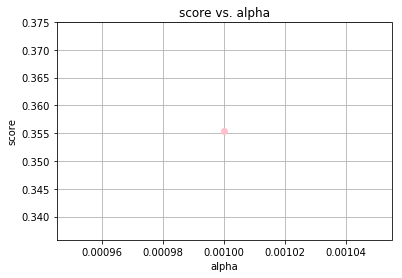

The optimaized alpha and score of Lasso linear is:  0.001 0.355373443703179
989.3041594028473  sec


In [28]:
A = time.time()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing

lr_train, lr_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

lr_train_x = lr_train.drop(['trip_duration'], axis = 1)
lr_validate_x = lr_validate.drop(['trip_duration'], axis = 1)
lr_train_y = lr_train['trip_duration']
lr_validate_y = lr_validate['trip_duration']

B = time.time()
print(B - A,' sec')

del lr_train
del lr_validate

alphas = np.logspace(-3, 0, num=1)             # plot one point to see the score since computation takes too much time 
# alphas= [0.000000001]

scores = np.empty_like(alphas)
opt_a = float('-inf')            #  The optimaized alpha
max_score = float('-inf')        #  score of Lasso linear

for i, a in enumerate(alphas):
    lasso = sl.linear_model.Lasso(alpha = a,tol=0.01,normalize=False,max_iter=1000,selection='random')                   # imported sklearn as sl
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='pink', linestyle='dashed', marker='o',markerfacecolor='pink', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

C = time.time()
print(C - B,' sec')

In [29]:
lasso.score(model_test_x,model_test_y)

0.3500078135532597

#### I plotted several points before this one actually. However, due to the fact that the cumputation is too large, I failed to show them here. But I recorded the result which the score of Lasso linear model kept increasing as the alpha reaching 0.001.

# --------------------------------------------------------------------------------------------------------------

### 3.1.2 Linear Regression

In [4]:
A = time.time()

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

Linear = LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)
Linear.fit(model_train_x.to_numpy(),model_train_y.to_numpy())

C = time.time()
print(C - A,' sec')

37.79152297973633  sec


In [5]:
Linear.score(model_train_x,model_train_y)

0.35078293022742313

# --------------------------------------------------------------------------------------------------------------

## 3.2 Non-Linear Models

### 3.2.1 Decision Tree

In [14]:
# A = time.time()

# from sklearn.tree import DecisionTreeRegressor

# Tree = DecisionTreeRegressor(
#     criterion='mse',
#     splitter='best',
#     max_depth=None,
#     min_samples_split=2, 
#     min_samples_leaf=1, 
#     min_weight_fraction_leaf=0.0, 
#     max_features=None, 
#     random_state=None, 
#     max_leaf_nodes=None, 
#     min_impurity_decrease=0.0, 
#     min_impurity_split=None, 
#     presort=False)

# Tree.fit(model_train_x,model_train_y)

# C = time.time()
# print(C - A,' sec')

In [15]:
# Tree.score(model_test_x,model_test_y)

In [9]:
A = time.time()
dt_train, dt_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

dt_train_x = dt_train.drop(['trip_duration'], axis = 1)
dt_validate_x = dt_validate.drop(['trip_duration'], axis = 1)
dt_train_y = dt_train['trip_duration']
dt_validate_y = dt_validate['trip_duration']

from sklearn.tree import DecisionTreeRegressor

Tree = DecisionTreeRegressor(
    criterion='mse',
    splitter='best',
    max_depth=None,
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    presort=False)

Tree.fit(dt_train_x, dt_train_y)

C = time.time()
print(C - A,' sec')

174.41580057144165  sec


In [11]:
A = time.time()
print(Tree.score(dt_validate_x, dt_validate_y))
C = time.time()
print(C - A,' sec')

0.6208320027652228
0.4228687286376953  sec


# --------------------------------------------------------------------------------------------------------------

### 3.2.2 Random Forest

In [5]:
A = time.time()

rf_train, rf_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

rf_train_x = rf_train.drop(['trip_duration'], axis = 1)
rf_validate_x = rf_validate.drop(['trip_duration'], axis = 1)
rf_train_y = rf_train['trip_duration']
rf_validate_y = rf_validate['trip_duration']


from sklearn.ensemble import RandomForestRegressor

Forest = RandomForestRegressor(
    n_estimators=10,
    criterion='mse', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=None, 
    verbose=0, 
    warm_start=False)

Forest.fit(rf_train_x, rf_train_y)

C = time.time()
print(C - A,' sec')

540.7030777931213  sec


In [6]:
A = time.time()
print(Forest.score(rf_validate_x, rf_validate_y))
C = time.time()
print(C - A,' sec')

0.6240470024182512
0.5988695621490479  sec


# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------

# Part 4. Model Evaluation

#### Test data is the reserved 20% of the whole dataset, and has never been seen by the above models.

## 4.1 Linear Regression (L)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

L_score = Linear.score(model_test_x, model_test_y)

pred_y = Linear.predict(model_test_x)
MSE_L = mean_squared_error(model_test_y, pred_y)
RMSE_L = sqrt(mean_squared_error(model_test_y, pred_y))

# The mean squared error and root mean square error
print('L score: ', L_score)
print('Mean square error of L: ', MSE_L)
print('Root mean squared error of L:', RMSE_L)
# print('Coefficients: \n', ridge_fp.coef_)

L score:  -257137827122899.38
Mean square error of L:  1.809571689238277e+20
Root mean squared error of L: 13452032148.48328


# --------------------------------------------------------------------------------------------------------------

## 4.2 Decision Tree (dt)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

dt_score = Tree.score(model_test_x, model_test_y)

pred_y = Tree.predict(model_test_x)
MSE_dt = mean_squared_error(model_test_y, pred_y)
RMSE_dt = sqrt(mean_squared_error(model_test_y, pred_y))

# The mean squared error and root mean square error
print('dt score: ', dt_score)
print('Mean square error of dt: ', MSE_dt)
print('Root mean squared error of dt:', RMSE_dt)
# print('Coefficients: \n', ridge_fp.coef_)

dt score:  0.6033322654016876
Mean square error of dt:  279149.4003798644
Root mean squared error of dt: 528.3459097786831


# --------------------------------------------------------------------------------------------------------------

## 4.3 Random Forest (rf)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rf_score = Forest.score(model_test_x, model_test_y)

pred_y = Forest.predict(model_test_x)
MSE_rf = mean_squared_error(model_test_y, pred_y)
RMSE_rf = sqrt(mean_squared_error(model_test_y, pred_y))

# The mean squared error and root mean square error
print('rf score: ', rf_score)
print('Mean square error of rf: ', MSE_rf)
print('Root mean squared error of rf:', RMSE_rf)
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.6098187076023989
Mean square error of rf:  274584.6569107219
Root mean squared error of rf: 524.008260345886


In [9]:
Forest.score(model_train_x,model_train_y)

0.6647866526252718

# --------------------------------------------------------------------------------------------------------------

## 4.4 Comparison of the models

#### Compared the max_score, mean squared error (MSE), and root mean squared error (RMSE) of the models.
#### Random forest model rf returns the beset prediction accuracy.

No handles with labels found to put in legend.


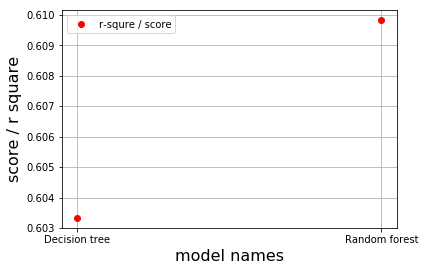

No handles with labels found to put in legend.


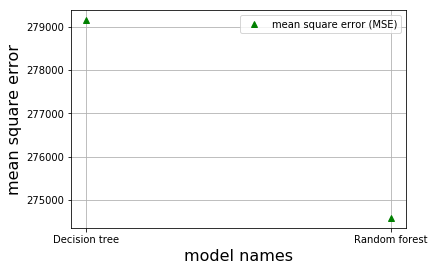

No handles with labels found to put in legend.


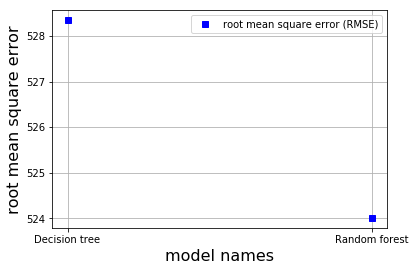

In [8]:
lst_score = [0.6033322654016876, 0.6098187076023989]
MSE_lst =  [279149.4003798644, 274584.6569107219]
RMSE_lst =  [528.3459097786831, 524.008260345886]
model_lst = ['Decision tree', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(loc = 9)
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(loc = 9)
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(loc = 9)
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

In [11]:
from joblib import dump
dump(Forest,'RF.joblib')

['RF.joblib']

#### As can be seen from the results of the test sets, the random forest ranks the first place. I will use it for the prediction.